# Predicting Bounding Boxes


In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<a name="0-5"></a>
## 0.5 Imports

In [3]:
!pip install tfds-nightly

In [4]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [5]:
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

In [6]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):

    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):

    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):

    draw_bounding_boxes_on_image(image, boxes, color, thickness)

    return image

In [7]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)

      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])

      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

<a name="2"></a>
## 2. Preprocess and Load the Dataset

In [8]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x ,
                 bbox[1] / factor_y,
                 bbox[2] / factor_x ,
                 bbox[3] / factor_y]

    return image, bbox_list

In [9]:
def read_image_with_shape(image, bbox):
    original_image = image

    image, bbox_list = read_image_tfds(image, bbox)

    return original_image, image, bbox_list

In [ ]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x ,
                 bbox[0] * factor_y,
                 bbox[3] * factor_x,
                 bbox[2] * factor_y]
    return image, bbox_list

In [11]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)

    if N > 0:
        take_dataset = take_dataset.take(N)

    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())

    return (np.array(ds_images), np.array(ds_bboxes))

In [14]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):
    """Converts a dataset into numpy arrays of images and boxes.

    Args:
      dataset: The dataset to convert.
      batch_size: The batch size to use.
      N: The number of elements to take.

    Returns:
      A tuple containing the numpy arrays of images and bounding boxes.
    """

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)

    if N > 0:
        take_dataset = take_dataset.take(N)

    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())

    # Convert lists to NumPy arrays with object dtype to handle varying shapes
    ds_images = np.array(ds_images, dtype=object)
    ds_bboxes = np.array(ds_bboxes, dtype=object)

    return (ds_images, ds_bboxes)

In [38]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):
    """Converts a dataset into numpy arrays of images and boxes.
    Handles varying image shapes by resizing images to (224, 224, 3).

    Args:
      dataset: The dataset to convert.
      batch_size: The batch size to use.
      N: The number of elements to take.

    Returns:
      A tuple containing the numpy arrays of images and bounding boxes.
    """
    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)

    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []

    for original_images, images, bboxes in normalized_dataset:
        # Reshape images to (224, 224, 3) before appending
        images = images.numpy()
        images = images.reshape(-1, 224, 224, 3)  # Assuming images are (224, 224, 3)
        ds_images.append(images)
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    # Convert lists to NumPy arrays
    ds_original_images = np.array(ds_original_images, dtype=object)
    ds_images = np.concatenate(ds_images, axis=0)  # Concatenate images into a single array
    ds_bboxes = np.array(ds_bboxes, dtype=object)

    return ds_original_images, ds_images, ds_bboxes

Visualize the **training** images and their bounding box labels

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='https://www.vision.caltech.edu/datasets/cub_200_2011/',
    data_dir='/content/drive/My Drive/TF3 C3 W1 Data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),


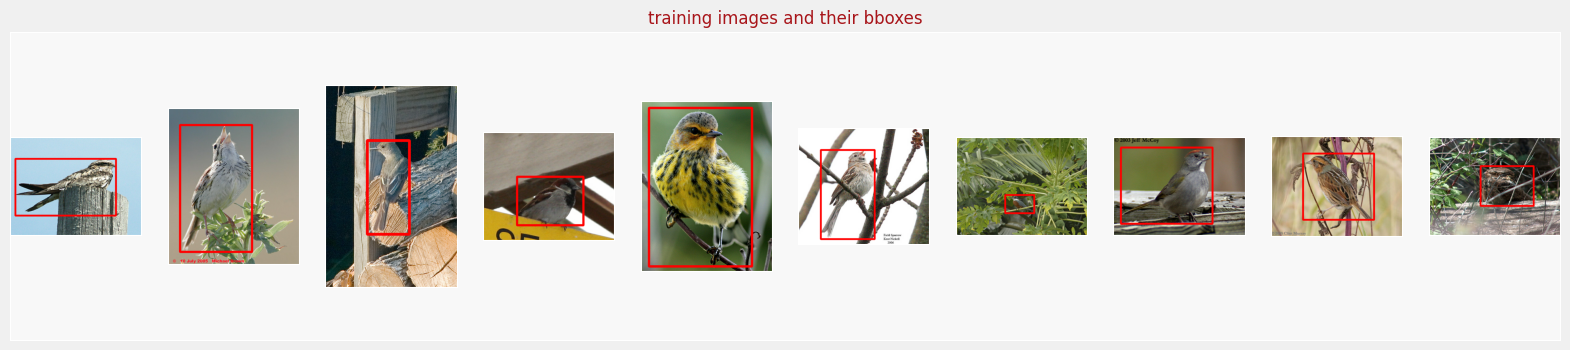

In [17]:
def get_visualization_training_dataset():
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox,
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

Visualize the **validation** images and their bounding boxes

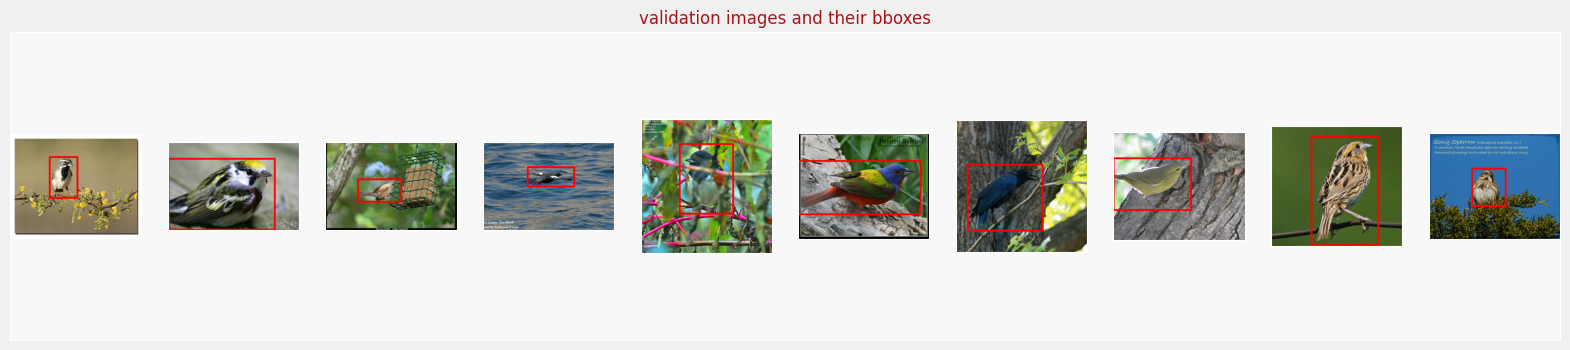

In [18]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True, data_dir=data_dir)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

<a name="2-3"></a>
### 2.3 Load and prepare the datasets for the model


In [19]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

In [20]:
def feature_extractor(inputs):

    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet'
    )


    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)

    # return the feature_extractor
    return feature_extractor

In [21]:
def dense_layers(features):

    # global average pooling 2D layer.
    x = tf.keras.layers.GlobalAveragePooling2D()(features)

    # flatten layer
    x = tf.keras.layers.Flatten()(x)

    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation='relu')(x)

    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    return x

In [22]:
def bounding_box_regression(x):

    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4, activation='linear', name='bounding_box')(x)

    return bounding_box_regression_output

In [23]:
def final_model(inputs):

    # features
    feature_cnn = feature_extractor(inputs)

    # dense layers
    last_dense_layer = dense_layers(feature_cnn)

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)

    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(inputs=inputs, outputs=bounding_box_output)

    return model

In [26]:
def define_and_compile_model():

    # define the input layer
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))

    # create the model
    model = final_model(inputs)

    # compile your model
    model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                  loss='mse',
                  metrics=['acc'])

    return model

Run the cell below to define your model and print the model summary.

In [27]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bounding_box (Dense)                 │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

<a name='4'></a>
## Train the Model

<a name='4.1'></a>
### 4.1 Prepare to Train the Model


In [29]:
import math

# You'll train 50 epochs
EPOCHS = 50

# Choose a batch size
BATCH_SIZE = 32

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = math.ceil(length_of_training_dataset / BATCH_SIZE)

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1


<a name='4.2'></a>
### 4.2 Fit the model to the data



In [30]:
# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(x=training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 86s 488ms/step - acc: 0.5044 - loss: 0.1627 - val_acc: 0.5034 - val_loss: 0.2196
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - acc: 0.6693 - loss: 0.0128 - val_acc: 0.5337 - val_loss: 0.1500
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 444ms/step - acc: 0.7392 - loss: 0.0085 - val_acc: 0.5622 - val_loss: 0.1038
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 443ms/step - acc: 0.7725 - loss: 0.0064 - val_acc: 0.5555 - val_loss: 0.0820
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 431ms/step - acc: 0.7844 - loss: 0.0054 - val_acc: 0.5701 - val_loss: 0.0639
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 434ms/step - acc: 0.8109 - loss: 0.0045 - val_acc: 0.5749 - val_loss: 0.0488
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 436ms/step - acc: 0.8360 - loss: 0.0038 - val_acc: 0.5855 - val_loss: 0.0441
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 436ms/step - acc: 0.8551 - loss: 0.0034 - val_acc: 0.5901 - val_loss: 0.0364
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 438ms/

<a name='5'></a>
## 5. Validate the Model

<a name='5-1'></a>
### 5.1 Loss



In [31]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - acc: 0.6334 - loss: 0.0148
Loss:  [0.014880823902785778, 0.6330077648162842]


<a name='5-2'></a>
### 5.2 Save the Model

In [32]:
model.save("birds.h5")

<a name='5-3'></a>
### 5.3 Plot Loss Function


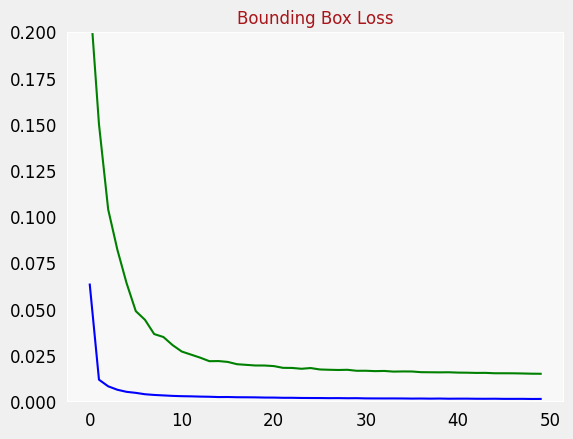

In [34]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

<a name='5-4'></a>
### 5.4 Evaluate performance using IoU


In [39]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step
Number of predictions where iou > threshold(0.5): 289
Number of predictions where iou < threshold(0.5): 211


<a name='6'></a>
## 6. Visualize Predictions


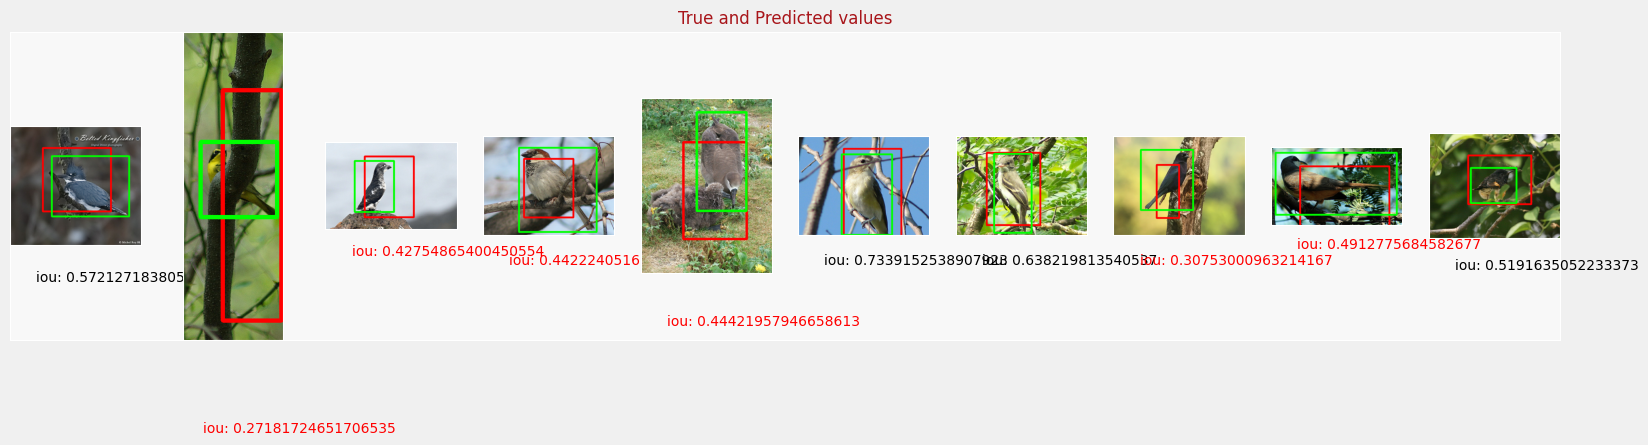

In [40]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)